In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt

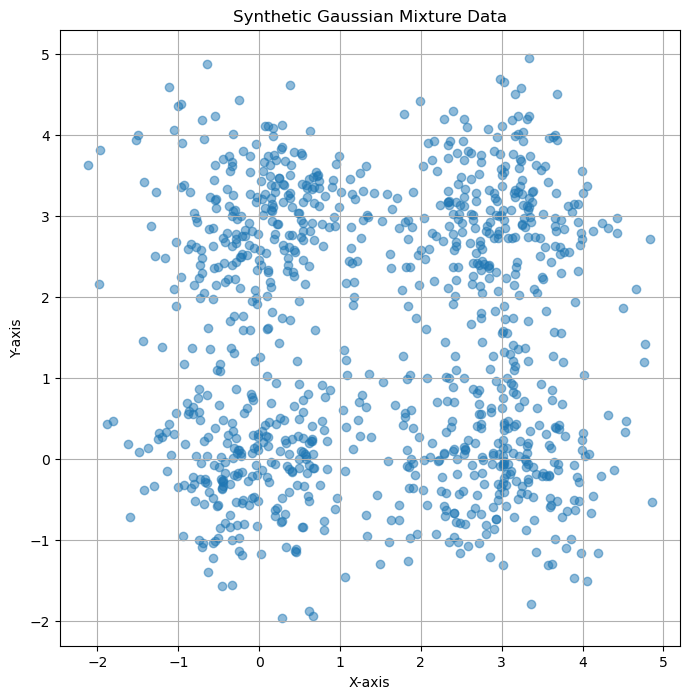

In [2]:
def generate_gaussian_mixture(num_samples=1000):
    np.random.seed(0)
    # Parameters for the Gaussian mixtures
    means = np.array([[0, 0], [3, 3], [0, 3], [3, 0]])
    cov = np.array([[0.5, 0], [0, 0.5]])
    
    samples = []
    for mean in means:
        samples.append(np.random.multivariate_normal(mean, cov, num_samples // len(means)))
    
    return np.vstack(samples)

# Generate synthetic data
data = generate_gaussian_mixture()

# Visualize the data
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.title('Synthetic Gaussian Mixture Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()
plt.show()

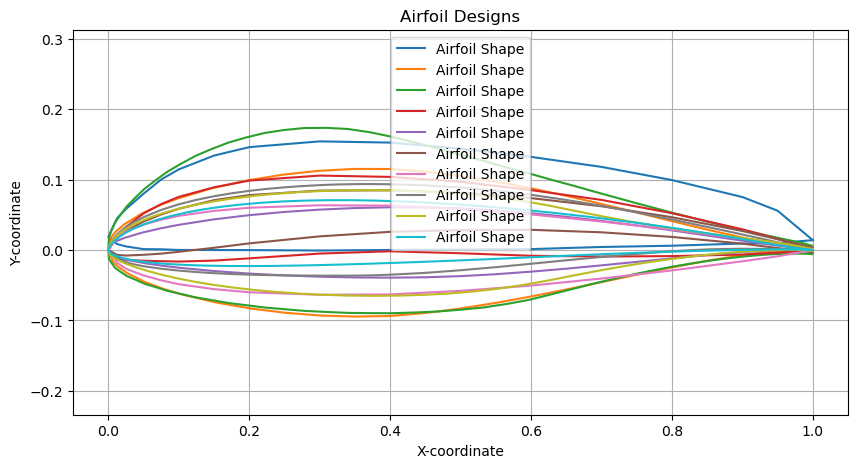

In [77]:
import os
import random

def load_airfoil_data(folder_path):
    # Load airfoil data from multiple .dat files in a folder
    airfoil_data = []
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.dat')]
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        data = np.loadtxt(file_path, skiprows=1)  # Assuming the first row is a header
        airfoil_data.append(data)
    return airfoil_data

def normalize_airfoil_data(airfoil_data):
    normalized_data = []
    for airfoil in airfoil_data:
        # Ensure each airfoil has exactly 51 points
        if len(airfoil) != 51:
            # Interpolate to get 51 points if needed
            x = np.linspace(0, 1, 51)
            y_interp = np.interp(x, np.linspace(0, 1, len(airfoil)), airfoil[:, 1])
            normalized = np.column_stack((x, y_interp))
        else:
            normalized = airfoil.copy()
        
        # Scale to [-1, 1]
        normalized = 2 * (normalized - normalized.min()) / (normalized.max() - normalized.min()) - 1
        normalized_data.append(normalized)
    
    return np.array(normalized_data)


def visualize_airfoil(airfoil_data, sample_size=10):
    plt.figure(figsize=(10, 5))
    sampled_data = random.sample(airfoil_data, min(sample_size, len(airfoil_data)))
    for data in sampled_data:
        plt.plot(data[:, 0], data[:, 1], label='Airfoil Shape')
    plt.title('Airfoil Designs')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.show()

# Load and visualize airfoil data
airfoil_data = load_airfoil_data('/Users/rishabh/Desktop/PADGAN/coord_seligFmt')  # Replace with your folder path
visualize_airfoil(airfoil_data, sample_size=10)
# Normalize the data
normalized_airfoils = normalize_airfoil_data(airfoil_data)

In [79]:
def build_performance_estimator(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),  # Specify input shape
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def construct_dpp_kernel(samples, quality_scores, gamma_0):
    # Flatten samples for distance computation
    flat_samples = tf.reshape(samples, (tf.shape(samples)[0], -1))
    
    # Compute pairwise distances
    samples_expanded_1 = tf.expand_dims(flat_samples, axis=1)
    samples_expanded_2 = tf.expand_dims(flat_samples, axis=0)
    
    # Compute squared distances using broadcasting
    squared_distances = tf.reduce_sum(tf.square(samples_expanded_1 - samples_expanded_2), axis=-1)
    
    # Compute similarity matrix using RBF kernel
    similarity_matrix = tf.exp(-0.5 * squared_distances)
    
    # Construct L kernel with quality scores
    quality_scores_expanded_1 = tf.expand_dims(quality_scores, 1)
    quality_scores_expanded_2 = tf.expand_dims(quality_scores, 0)
    quality_terms = quality_scores_expanded_1 * quality_scores_expanded_2
    quality_terms = tf.pow(quality_terms, gamma_0)
    L = similarity_matrix * quality_terms
    
    # Add small diagonal term for numerical stability
    L = L + tf.eye(tf.shape(L)[0]) * 1e-3
    
    return L

def padgan_loss(generated_samples, quality_scores, gamma_0):
    # Construct DPP kernel
    L = construct_dpp_kernel(generated_samples, quality_scores, gamma_0)
    
    # Add regularization to prevent numerical instability
    L = L + tf.eye(tf.shape(L)[0]) * 1e-3
    
    try:
        # Compute eigenvalues directly
        eigvals = tf.linalg.eigvals(L)
        # Use only real parts and add small constant
        eigvals = tf.math.real(eigvals) + 1e-7
        log_det = tf.reduce_sum(tf.math.log(tf.abs(eigvals)))
    except tf.errors.InvalidArgumentError:
        # Fallback to a small negative value if decomposition fails
        log_det = -1e3
        
    return -log_det / tf.cast(tf.shape(generated_samples)[0], tf.float32)

def build_generator(latent_dim, num_points=51):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dense(1024),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dense(num_points * 2, activation='tanh'),
        layers.Reshape((num_points, 2))
    ])
    return model

def build_discriminator(input_shape):
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

class PaDGAN:
    def __init__(self, latent_dim, gamma_0=2.0, gamma_1=0.5):
        self.latent_dim = latent_dim
        self.gamma_0 = gamma_0
        self.gamma_1 = gamma_1
        
        input_shape = (51, 2)
        
        # Build models
        self.generator = build_generator(latent_dim)
        self.discriminator = build_discriminator(input_shape)  # Pass input shape directly
        self.performance_estimator = build_performance_estimator(input_shape)  # Pass input shape directly
        
        # Initialize optimizers with lower learning rates
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        
        
    def train_step(self, real_samples, batch_size):
        real_samples = tf.cast(real_samples, tf.float32)
        
        # Generate random noise
        noise = tf.random.normal([batch_size, self.latent_dim])
        
        # Train discriminator
        with tf.GradientTape() as tape:
            generated_samples = self.generator(noise, training=True)
            real_output = self.discriminator(real_samples, training=True)
            fake_output = self.discriminator(generated_samples, training=True)
            
            # Add small epsilon to prevent log(0)
            epsilon = 1e-7
            d_loss = -tf.reduce_mean(tf.math.log(real_output + epsilon) + 
                                   tf.math.log(1 - fake_output + epsilon))
            
        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        d_gradients, _ = tf.clip_by_global_norm(d_gradients, 1.0)
        self.d_optimizer.apply_gradients(zip(d_gradients, 
                                           self.discriminator.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as tape:
            generated_samples = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_samples, training=True)
            quality_scores = self.performance_estimator(generated_samples)
            
            g_loss_gan = -tf.reduce_mean(tf.math.log(fake_output + epsilon))
            g_loss_pad = padgan_loss(generated_samples, quality_scores, 
                                   self.gamma_0)
            g_loss = g_loss_gan + self.gamma_1 * tf.clip_by_value(g_loss_pad, -1e3, 1e3)
            
        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        g_gradients, _ = tf.clip_by_global_norm(g_gradients, 1.0)
        self.g_optimizer.apply_gradients(zip(g_gradients, 
                                           self.generator.trainable_variables))
        
        return d_loss, g_loss
    
# Initialize PaDGAN
padgan = PaDGAN(latent_dim=100)

# Training parameters
epochs = 10000
batch_size = 32

# Training loop
for epoch in range(epochs):
    # Get batch of real samples
    idx = np.random.randint(0, len(normalized_airfoils), batch_size)
    real_batch = np.array([np.pad(normalized_airfoils[i][:51], ((0, 51-len(normalized_airfoils[i][:51])), (0,0)), 
                                 mode='constant') for i in idx])
    
    # Training step
    d_loss, g_loss = padgan.train_step(real_batch, batch_size)
    
    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

Epoch 0, D Loss: 1.4250, G Loss: 37.3051
Epoch 100, D Loss: 0.0147, G Loss: 19.9351
Epoch 200, D Loss: 0.0047, G Loss: 13.3465
Epoch 300, D Loss: 0.0021, G Loss: 12.0739
Epoch 400, D Loss: 0.0017, G Loss: 10.7917
Epoch 500, D Loss: 0.0014, G Loss: 11.0852
Epoch 600, D Loss: 0.0019, G Loss: 12.0282
Epoch 700, D Loss: 0.0010, G Loss: 12.8604
Epoch 800, D Loss: 0.0005, G Loss: 13.6130
Epoch 900, D Loss: 0.0012, G Loss: 14.0163
Epoch 1000, D Loss: 0.0010, G Loss: 14.9716
Epoch 1100, D Loss: 0.0004, G Loss: 15.3237
Epoch 1200, D Loss: 0.0005, G Loss: 15.4529
Epoch 1300, D Loss: 0.0004, G Loss: 16.1863
Epoch 1400, D Loss: 0.0001, G Loss: 15.8647
Epoch 1500, D Loss: 0.0001, G Loss: 16.3361
Epoch 1600, D Loss: 0.0001, G Loss: 16.7609
Epoch 1700, D Loss: 0.0001, G Loss: 17.1031
Epoch 1800, D Loss: 0.0001, G Loss: 16.6101
Epoch 1900, D Loss: 0.0001, G Loss: 16.9264
Epoch 2000, D Loss: 0.0001, G Loss: 17.1973
Epoch 2100, D Loss: 0.0002, G Loss: 17.9857
Epoch 2200, D Loss: 0.0001, G Loss: 18.1724


In [43]:
# Print basic information about the data
print(f"Number of airfoils: {len(airfoil_data)}")
print(f"Shape of first airfoil: {airfoil_data[0].shape}")
print(f"Data type: {type(airfoil_data[100])}")

# Print first few rows of first airfoil
print("\nFirst few rows of first airfoil:")
print(airfoil_data[0][:5])

Number of airfoils: 1621
Shape of first airfoil: (51, 2)
Data type: <class 'numpy.ndarray'>

First few rows of first airfoil:
[[1.0000e+00 2.1000e-04]
 [9.5027e-01 7.8500e-03]
 [9.0052e-01 1.5510e-02]
 [8.5074e-01 2.3010e-02]
 [8.0076e-01 3.0370e-02]]


Generated samples shape before reshape: (10, 51, 2)


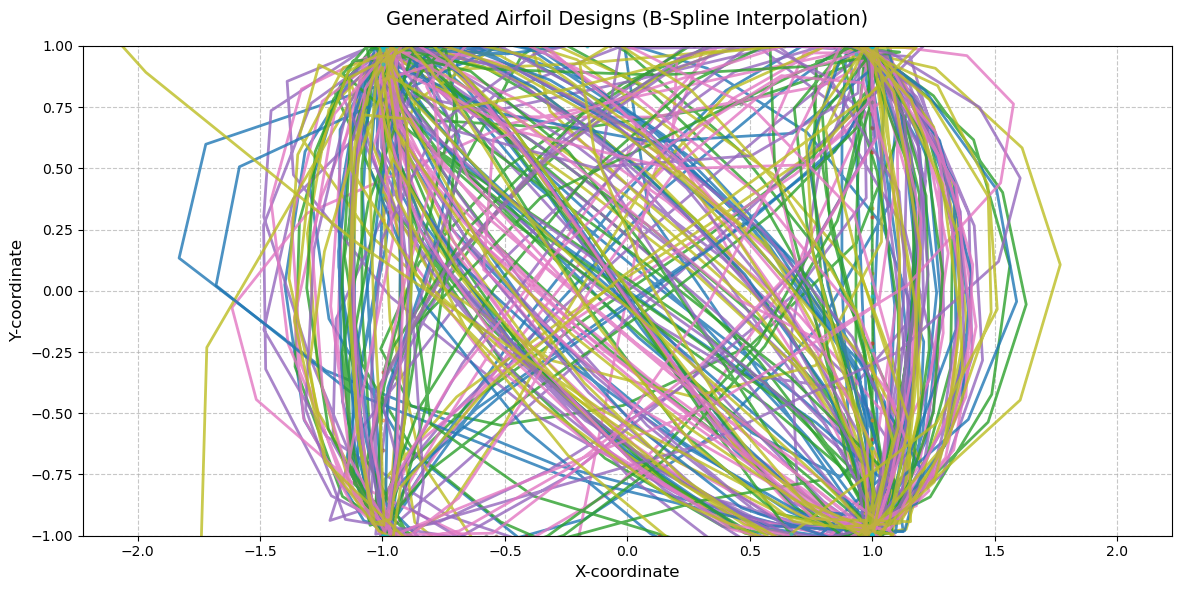


Quality scores for generated samples:
Airfoil 1: 0.9959
Airfoil 2: 0.9959
Airfoil 3: 0.9958
Airfoil 4: 0.9960
Airfoil 5: 0.9959
Airfoil 6: 0.9962
Airfoil 7: 0.9962
Airfoil 8: 0.9965
Airfoil 9: 0.9961
Airfoil 10: 0.9962


In [83]:
def generate_new_airfoils(padgan, num_samples=10):
    # Import scipy.interpolate
    from scipy import interpolate
    
    # Generate random noise vectors
    noise = tf.random.normal([num_samples, padgan.latent_dim])
    
    # Generate samples using the trained generator
    generated_samples = padgan.generator(noise, training=False)
    
    # Convert to numpy for plotting
    generated_samples = generated_samples.numpy()
    
    # Print shape for debugging
    print(f"Generated samples shape before reshape: {generated_samples.shape}")
    
    # We know we want 51 points per airfoil
    num_points = 51
    
    # Verify the reshape dimensions are valid
    if generated_samples.size != num_samples * num_points * 2:
        raise ValueError(f"Generated samples size {generated_samples.size} does not match expected size {num_samples * num_points * 2}")
    
    # Reshape the samples to have x,y coordinates based on actual size
    generated_samples = generated_samples.reshape(num_samples, num_points, 2)
    
    # Visualize the generated samples
    plt.figure(figsize=(12, 6))
    
    # Plot generated airfoils with B-spline interpolation
    for sample in generated_samples:
        # Create B-spline representation
        x = sample[:, 0]
        y = sample[:, 1]
        
        # Create parameter t based on cumulative distance
        t = np.zeros(len(x))
        for i in range(1, len(x)):
            t[i] = t[i-1] + np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2)
        t = t/t[-1]  # Normalize to [0, 1]
        
        # Create B-spline curves (degree=3 for cubic spline)
        tck = interpolate.splrep(t, x, s=0, k=3)
        tck_y = interpolate.splrep(t, y, s=0, k=3)
        
        # Generate points for smooth curve
        tnew = np.linspace(0, 1, 200)
        xnew = interpolate.splev(tnew, tck, der=0)
        ynew = interpolate.splev(tnew, tck_y, der=0)
        
        # Plot the smooth curve
        plt.plot(xnew, ynew, linewidth=2, alpha=0.8)
        # Plot original points
        plt.plot(x, y, 'o', markersize=2, alpha=0.5)
    
    plt.title('Generated Airfoil Designs (B-Spline Interpolation)', fontsize=14, pad=15)
    plt.xlabel('X-coordinate', fontsize=12)
    plt.ylabel('Y-coordinate', fontsize=12)
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(-2.0, 2.0)  # Set reasonable x-axis limits
    plt.ylim(-1.0, 1.0)  # Set reasonable y-axis limits
    plt.tight_layout()
    plt.show()
    
    return generated_samples

# Generate and visualize new airfoils
new_airfoils = generate_new_airfoils(padgan, num_samples=10)

# Print quality scores for generated samples
# Reshape while preserving the original structure (51 points per airfoil)
reshaped_airfoils = new_airfoils.reshape(new_airfoils.shape[0], -1, 2)
quality_scores = padgan.performance_estimator(reshaped_airfoils)
print("\nQuality scores for generated samples:")
for i, score in enumerate(quality_scores):
    print(f"Airfoil {i+1}: {score[0]:.4f}")


In [82]:
new_airfoils.shape

(1, 51, 2)